<a href="https://colab.research.google.com/github/claudiasofiaC/DS-Unit-2-Linear-Models/blob/master/assignment_3_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html). Use the scaler's `fit_transform` method with the train set. Use the scaler's `transform` method with the test set.
- [ ] Fit a ridge regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [6]:
df['SALE_PRICE'].value_counts()

0          6909
10          199
800000      125
750000      121
650000      120
           ... 
5236177       1
229000        1
397218        1
4112000       1
1751425       1
Name: SALE_PRICE, Length: 3831, dtype: int64

In [7]:
df.shape

(23040, 21)

In [0]:
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'])
df_copy = df[df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS']
df_copy = df_copy[df_copy['SALE_PRICE'] < 2000000]
df_copy = df_copy[df_copy['SALE_PRICE'] > 100000]
df_copy = df_copy.drop(['EASE-MENT'], axis=1)

In [9]:
df_copy['SALE_PRICE'].value_counts()

500000    48
550000    43
450000    40
525000    40
650000    36
          ..
413000     1
672045     1
457000     1
608550     1
727000     1
Name: SALE_PRICE, Length: 1000, dtype: int64

In [18]:
df_copy.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,2019-01-01
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,2019-01-01
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,2019-01-02
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,2019-01-02
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,2019-01-02


In [0]:
#SPLIT DATA

train = df_copy[df_copy['SALE_DATE'].dt.month < 4]

test = df_copy[df_copy['SALE_DATE'].dt.month ==4]

In [11]:
train['SALE_DATE'].describe()

count                    2507
unique                     68
top       2019-01-31 00:00:00
freq                       78
first     2019-01-01 00:00:00
last      2019-03-30 00:00:00
Name: SALE_DATE, dtype: object

In [22]:
train.head(1)

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,2019-01-01


In [23]:
test.head(1)

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
18235,2,OTHER,01 ONE FAMILY DWELLINGS,1,5913,878,A1,4616 INDEPENDENCE AVENUE,NaN,10471.0,1.0,0.0,1.0,"5,000",2272.0,1930.0,1,A1,895000,2019-04-01


In [12]:
test['SALE_PRICE'].mean()

655757.054347826

In [13]:
#rREMOVING HIGH CARDINALITY
#aAND 1 UNIQU FEATURE

df_copy.describe(include=object)

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,LAND_SQUARE_FEET,BUILDING_CLASS_AT_TIME_OF_SALE
count,3151,3151,3151,3151,3151,3151,1,3151,3151
unique,5,6,1,2,13,3135,1,1035,11
top,4,OTHER,01 ONE FAMILY DWELLINGS,1,A1,22-40 93RD STREET,RP.,"4,000",A1
freq,1580,2990,3151,3111,1185,2,1,289,1186


In [14]:
df_copy.describe()

,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE
count,3151.000000,3151.000000,3151.000000,3151.000000,3151.000000,3151.000000,3151.000000,3151.000000,3151.0,3.151000e+03
mean,6917.976515,75.981593,11027.219613,0.987623,0.015868,1.003491,1470.306887,1943.694700,1.0,6.285601e+05
std,3963.326705,161.089514,482.875284,0.113414,0.127499,0.171789,586.339200,26.676786,0.0,2.929904e+05
min,21.000000,1.000000,10030.000000,0.000000,0.000000,0.000000,0.000000,1890.000000,1.0,1.040000e+05
25%,4016.000000,21.000000,10461.000000,1.000000,0.000000,1.000000,1144.000000,1925.000000,1.0,4.475000e+05
50%,6301.000000,42.000000,11235.000000,1.000000,0.000000,1.000000,1360.000000,1938.000000,1.0,5.680000e+05
75%,10208.500000,69.000000,11413.000000,1.000000,0.000000,1.000000,1683.000000,1955.000000,1.0,7.600000e+05
max,16350.000000,2720.000000,11697.000000,2.000000,2.000000,3.000000,7875.000000,2018.000000,1.0,1.955000e+06


In [0]:
target = 'SALE_PRICE'
high_cardinality = ['ADDRESS', 'APARTMENT_NUMBER',
                    'LAND_SQUARE_FEET', 'SALE_DATE',
                    'BUILDING_CLASS_CATEGORY', 'APARTMENT_NUMBER',
                    'BUILDING_CLASS_AT_PRESENT', 'BUILDING_CLASS_AT_TIME_OF_SALE',
                    'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'GROSS_SQUARE_FEET']
features = train.columns.drop([target] + high_cardinality)

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [21]:
y_train

44       550000
61       200000
78       810000
108      125000
111      620000
          ...  
18129    330000
18130    690000
18132    610949
18134    520000
18147    104000
Name: SALE_PRICE, Length: 2507, dtype: int64

In [22]:
#ONE HOT ENCODING

import category_encoders as ce

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)
X_train.shape

(2507, 19)

In [23]:
X_train.head(1)

,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_ASTORIA,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE
44,1,0,0,0,0,1,0,0,0,0,0,1,0,5495,801,11230.0,1.0,1930.0,1


In [0]:
#SELECTING FEATURES W SELECTKBEST

from sklearn.feature_selection import f_regression, SelectKBest

In [31]:
selector = SelectKBest(score_func = f_regression, k = 10)

X_train_selected = selector.fit_transform(X_train, y_train)

X_test_selected = selector.transform(X_test)



/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [30]:
X_train_selected.shape, X_test_selected.shape

((2507, 10), (644, 10))

In [34]:
all_names = X_train.columns

selected_mask = selector.get_support()

selected_names = all_names[selected_mask]

unselected_names = all_names[~selected_mask]

print('Featuers Selected: ')
for name in selected_names:
  print(name)

print('\n')
print('Features not Selected: ')
for name in unselected_names: 
  print(name) 

Featuers Selected: 
BOROUGH_3
BOROUGH_4
BOROUGH_2
BOROUGH_5
NEIGHBORHOOD_OTHER
NEIGHBORHOOD_FLUSHING-NORTH
NEIGHBORHOOD_FOREST HILLS
NEIGHBORHOOD_BOROUGH PARK
BLOCK
ZIP_CODE


Features not Selected: 
BOROUGH_1
NEIGHBORHOOD_BEDFORD STUYVESANT
NEIGHBORHOOD_ASTORIA
TAX_CLASS_AT_PRESENT_1
TAX_CLASS_AT_PRESENT_1D
LOT
RESIDENTIAL_UNITS
YEAR_BUILT
TAX_CLASS_AT_TIME_OF_SALE


In [35]:
#FITTING RIDGE REGRESSION

import math
train['SALE_PRICE'].mean()

621573.7423214999

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#LINEAR REGRESSION FOR SELECTKBEST FEATURE

lin_reg = LinearRegression()
lin_reg.fit(X_train_selected, y_train)

print(f'MSE: {mean_squared_error(y_test, lin_reg.predict(X_test_selected))}')
print(f'MAE: {mean_absolute_error(y_test, lin_reg.predict(X_test_selected))}')




MSE: 69320525324.35219
MAE: 183868.0011820088


In [0]:
from sklearn.linear_model import Ridge


In [40]:
#RIDGE REGRESSION FOR SELECTKBEST FEATURES

ridge_reg = Ridge(alpha=1).fit(X_train_selected, y_train)

print(f'MSE: {mean_squared_error(y_test, ridge_reg.predict(X_test_selected))}')

print(f'MAE: {mean_absolute_error(y_test, ridge_reg.predict(X_test_selected))}')


MSE: 69530203766.32266
MAE: 184005.56811860035


In [43]:
#RIDGE REGRESSION FOR ALL FEATURES

ridge_reg = Ridge(alpha=1).fit(X_train, y_train)

print(f'MSE: {mean_squared_error(y_test, ridge_reg.predict(X_test))}')

print(f'MAE: {mean_absolute_error(y_test, ridge_reg.predict(X_test))}')

MSE: 70782226874.94672
MAE: 185127.73578568312


In [45]:
#MSE AND MAE V. SALE_PRICE MEAN

sale_price_mean = []

for _ in y_test:
  sale_price_mean.append(train['SALE_PRICE'].mean())

print(f'MSE: {mean_squared_error(y_test, sale_price_mean)}')  

print(f'MAE: {mean_absolute_error(y_test, sale_price_mean)}')

MSE: 89228639961.4915
MAE: 211564.20053849227


In [0]:
#STANDARDIZE DATA
#ooooof

alphas = []
mses = []
maes = []

for alpha in range(1, 2000, 1):
    ridge_reg_split = Ridge(alpha=alpha).fit(X_train, y_train)
    mse = mean_squared_error(y_test, ridge_reg_split.predict(X_test))
    mae = mean_absolute_error(y_test, ridge_reg_split.predict(X_test))
    # print(alpha, mse)
    alphas.append(alpha)
    mses.append(mse)
    maes.append(mae)

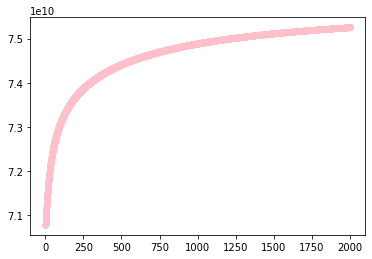

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(alphas, mses, color='pink');
